In [41]:
%matplotlib widget

In [42]:
import pandas as pd
import numpy as np
from glob import glob
import os
import datetime
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Concatenate, Dot, Add, ReLU, Activation
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras

In [43]:
import matplotlib
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
font_location = '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf'
#font_location = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
# font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
fprop = fm.FontProperties(fname=font_location)

# Time Lag correlation

**한강 팔당상수원(가평,의암)**

In [116]:
folder = 'data'
file_names = [['가평_2016.xlsx','가평_2017.xlsx','가평_2018.xlsx', '가평_2019.xlsx'], ['의암호_2016.xlsx','의암호_2017.xlsx','의암호_2018.xlsx', '의암호_2019.xlsx']]
#file_names = [['해평_2016.xlsx','해평_2017.xlsx','해평_2018.xlsx', '해평_2019.xlsx'], ['도개_2016.xlsx','도개_2017.xlsx','도개_2018.xlsx', '도개_2019.xlsx']]
#file_names = [['가평_2019.xlsx'], ['의암호_2019.xlsx']]

day = 24*60*60
year = (365.2425)*day

df_full = []
df = []

for loc in range(len(file_names)):
    
    df_loc = []
    for y in range(len(file_names[loc])):
        path = os.path.join(folder, file_names[loc][y])
        print(file_names[loc][y])
        df_loc.append(pd.read_excel(path))
    df_full.append(pd.concat(df_loc))
    df.append(df_full[loc].iloc[:, [2,3,4,5,6,7,10]].copy())
    date_time = pd.to_datetime(df_full[loc].iloc[:, 0], format='%Y.%m.%d %H:%M', utc=True)
    timestamp_s = date_time.map(datetime.datetime.timestamp)
    df[loc]['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df[loc]['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df[loc]['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df[loc]['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    df[loc] = df[loc].reset_index(drop=True)

가평_2016.xlsx
가평_2017.xlsx
가평_2018.xlsx
가평_2019.xlsx
의암호_2016.xlsx
의암호_2017.xlsx
의암호_2018.xlsx
의암호_2019.xlsx


**낙동강 상수원(해평,도개)**

In [44]:
folder = 'data'
#file_names = [['가평_2016.xlsx','가평_2017.xlsx','가평_2018.xlsx', '가평_2019.xlsx'], ['의암호_2016.xlsx','의암호_2017.xlsx','의암호_2018.xlsx', '의암호_2019.xlsx']]
file_names = [['해평_2016.xlsx','해평_2017.xlsx','해평_2018.xlsx', '해평_2019.xlsx'], ['도개_2016.xlsx','도개_2017.xlsx','도개_2018.xlsx', '도개_2019.xlsx']]
#file_names = [['가평_2019.xlsx'], ['의암호_2019.xlsx']]

day = 24*60*60
year = (365.2425)*day

df_full = []
df = []

for loc in range(len(file_names)):
    
    df_loc = []
    for y in range(len(file_names[loc])):
        path = os.path.join(folder, file_names[loc][y])
        print(file_names[loc][y])
        df_loc.append(pd.read_excel(path))
    df_full.append(pd.concat(df_loc))
    if loc == 0:
        df.append(df_full[loc].iloc[:, 2:9].copy())
    else:
        df.append(df_full[loc].iloc[:, [2,3,4,5,6,7,10]].copy())
    date_time = pd.to_datetime(df_full[loc].iloc[:, 0], format='%Y.%m.%d %H:%M', utc=True)
    timestamp_s = date_time.map(datetime.datetime.timestamp)
    df[loc]['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df[loc]['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df[loc]['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df[loc]['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    df[loc] = df[loc].reset_index(drop=True)
        

해평_2016.xlsx
해평_2017.xlsx
해평_2018.xlsx
해평_2019.xlsx
도개_2016.xlsx
도개_2017.xlsx
도개_2018.xlsx
도개_2019.xlsx


**Normalization**

In [45]:
# normalize data

df_all = pd.concat(df)
df_all

train_mean = df_all.mean()
train_std = df_all.std()
for i in range(len(file_names)):
    df[i] = (df[i]-train_mean)/train_std

**GAIN**

In [46]:
train_df = df[0]
val_df = df[0]
test_df = df[0]

In [47]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
            #train_df=None, val_df=None, test_df=None,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [48]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [49]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(10, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]', fontproperties=fprop)
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [50]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [51]:
def sample_batch_index(total, batch_size):
    '''Sample index of the mini-batch.

    Args:
        - total: total number of samples
        - batch_size: batch size

    Returns:
        - batch_idx: batch index
    '''
    total_idx = np.random.permutation(total)
    batch_idx = total_idx[:batch_size]
    return batch_idx

In [52]:
def binary_sampler(p, shape):
  '''Sample binary random variables.
  
  Args:
    - p: probability of 1
    - shape: matrix shape
    
  Returns:
    - binary_random_matrix: generated binary random matrix.
  '''
  unif_random_matrix = np.random.uniform(0., 1., size = shape)
  binary_random_matrix = 1*(unif_random_matrix < p)
  return binary_random_matrix

In [53]:
def uniform_sampler(low, high, shape):
  '''Sample uniform random variables.
  
  Args:
    - low: low limit
    - high: high limit
    - rows: the number of rows
    - cols: the number of columns
    
  Returns:
    - uniform_random_matrix: generated uniform random matrix.
  '''
  return np.random.uniform(low, high, size = shape)

In [54]:
def normalization (data, parameters=None):
  '''Normalize data in [0, 1] range.
  
  Args:
    - data: original data
  
  Returns:
    - norm_data: normalized data
    - norm_parameters: min_val, max_val for each feature for renormalization
  '''

  # Parameters
  _, dim = data.shape
  norm_data = data.copy()

  if parameters is None:

    # MixMax normalization
    min_val = np.zeros(dim)
    max_val = np.zeros(dim)
   
    # For each dimension
    for i in range(dim):
      min_val[i] = np.nanmin(norm_data[:,i])
      norm_data[:,i] = norm_data[:,i] - np.nanmin(norm_data[:,i])
      max_val[i] = np.nanmax(norm_data[:,i])
      norm_data[:,i] = norm_data[:,i] / (np.nanmax(norm_data[:,i]) + 1e-6)

    # Return norm_parameters for renormalization
    norm_parameters = {'min_val': min_val,
                       'max_val': max_val}
  else:
    min_val = parameters['min_val']
    max_val = parameters['max_val']

    # For each dimension
    for i in range(dim):
      norm_data[:,i] = norm_data[:,i] - min_val[i]
      norm_data[:,i] = norm_data[:,i] / (max_val[i] + 1e-6)

    norm_parameters = parameters

  return norm_data, norm_parameters

In [55]:
class MissData(object):
    def __init__(self, load_dir=None):
        if load_dir:
            self.missarr = np.load(os.path.join(load_dir, 'miss.npy'))
            self.idxarr = np.load(os.path.join(load_dir, 'idx.npy'))
            
    def make_missdata(self, data_x, missrate=0.2):
        data = data_x.copy()
        rows, cols = data_x.shape
        total_no = rows*cols
        total_miss_no = np.round(total_no*missrate).astype(int)
        total_idx = self.idxarr.shape[0]
        idxarr = self.idxarr
        missarr = self.missarr
        #print(total_miss_no)
        miss_no = 0
        cum_no = self.idxarr[:,3:4]
        cum_no = cum_no.reshape((total_idx))
        cum_sum = np.max(cum_no)
        #print(cum_no)
        #print(total_idx)
        while True:
            loc_count = np.around(np.random.random()*cum_sum)
            #print('loc_count =', loc_count)
            idx = len(cum_no[cum_no <= loc_count])-1
            #print(cum_no[cum_no <= loc_count])
            #print('idx =', idx)
            startnan = idxarr[idx][0]
            nanlen = idxarr[idx][2]
            loc = np.around(np.random.random()*(rows-nanlen)).astype(int)
            #print('loc =', loc)
            #print(loc_count, idx)
            #print(idxarr[idx])
            #data_copy = data[loc:loc+nanlen].copy()
            data_copy = data[loc:loc+nanlen]
            #print('startnan=', startnan)
            #isnan = missarr[startnan:startnan+nanlen].copy()
            isnan = missarr[startnan:startnan+nanlen]
            #print('isnan =',isnan)
            miss_no += idxarr[idx][1]
            if (miss_no > total_miss_no):
                break
            data_copy[isnan==1] = np.nan
            data[loc:loc+nanlen] = data_copy
        #print('miss_data =', data)
        return data
    
    def save(data, max_tseq, save_dir='save'):
        no, dim = data.shape
        #print((no, dim))
        isnan = np.isnan(data).astype(int)
        isany = np.any(isnan, axis=1).astype(int)
        shifted = np.roll(isany, 1)
        shifted[0] = 1
        #print(isnan)
        #print(isany.astype(int))
        #print(shifted)
        startnan = ((isany == 1) & (shifted ==0)).astype(int)
        #print(startnan)
        group = startnan.cumsum()
        group = group*isany
        #print(group)
        n = np.max(group)
        #print(n)
        missarr = None
        cum_no = 0
        rowidx = 0
        for i in range(1, n+1):
            g = (group == i).astype(int)
            i = np.argmax(g)
            rows = g.sum()
            #print(len)
            #print(i)
            #print(type(missarr))
            if rows <= max_tseq:
                nanseq = isnan[i:i+rows, :]
                no = np.sum(nanseq)
                #print(no)
                if missarr is None:
                    missarr = nanseq
                    idxarr = np.array([[rowidx, no, rows, cum_no]])
                else:
                    missarr = np.concatenate((missarr, nanseq))
                    idxarr = np.concatenate((idxarr, [[rowidx, no, rows, cum_no]]), axis=0)
                cum_no += no
                rowidx += rows

        #print(idxarr)
        miss_npy_file = os.path.join(save_dir, 'miss.npy')
        idx_npy_file = os.path.join(save_dir, 'idx.npy')
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        np.save(miss_npy_file, missarr)
        np.save(idx_npy_file, idxarr)
        print('miss_data file saved')

In [56]:
norm_df = pd.concat(df,axis=0)
norm_data = norm_df.to_numpy()
MissData.save(norm_data, max_tseq = 24)

miss_data file saved


In [57]:
def interpolate(np_data, max_gap=3):
    #n = np_data.shape[1]
    data = pd.DataFrame(np_data)
    #data[0][0] = np.nan
    #data[0][1] = np.nan
    #data[0][2] = np.nan
    #data[data.columns[0]][0] = np.nan
    #data[data.columns[0]][1] = np.nan
    #data[data.columns[0]][2] = np.nan
    
    # create mask
    mask = data.copy()
    grp = ((mask.notnull() != mask.shift().notnull()).cumsum())
    grp['ones'] = 1
    for i in data.columns:
        mask[i] = (grp.groupby(i)['ones'].transform('count') < max_gap) | data[i].notnull()
    data = data.interpolate(method='polynomial', order=5, limit=max_gap, axis=0).bfill()[mask]
    return data.to_numpy()
    #return data
    
#filled_data = interpolate(norm_data, max_gap=3)
#np.arange(0, 5, dtype=int)
#['%d'%val for val in range(0,5)]

In [58]:
class GainDataGenerator(keras.utils.Sequence):
    'Generates data for GAIN'
    def __init__(self,
                 data_list,
                 batch_size=32,
                 input_width=24*3,
                 label_width=24*3,
                 shift=0,
                 fill_no=4,
                 miss_rate=0.2,
                 hint_rate=0.9,
                 normalize=True,
                 miss_pattern=None,
                 alpha=100.):
        'Initialization'
        window_size = input_width
        
        # interpollation
        filled_data = []
        for data in data_list:
            data = interpolate(data, max_gap=fill_no)
            filled_data.append(data)
            
        data_list = filled_data
        
        # whole data
        self.data = np.concatenate(data_list)

        # TO-DO
        
        # pre calculation for  sequence data
        last_cum = 0
        cums = []
        for data in data_list:
            isnan = np.isnan(data)
            isany = np.any(isnan, axis=1)
            #shift same as pd.shift(isany, fill_value=True)
            shifted = np.roll(isany, 1)
            shifted[0] = True # set to nan
            
            start_seq = ((isany == False) & (shifted == True)).astype(int)
            cum = start_seq.cumsum()
            cum += last_cum
            last_cum = np.max(cum)
            cum[isany] = 0
            cums.append(cum)
            
        
        # normlize for spam
        if normalize:
            self.data, norm_param = normalization(self.data)
        #print(norm_param)
        
        # Define mask matrix
        if miss_pattern is None:
            self.data_m = binary_sampler(1-miss_rate, self.data.shape)
        else:
            #MissData.save(self.data, max_tseq = 12)
            self.miss = MissData(load_dir='save')
            self.miss_rate = miss_rate
            miss_data = self.miss.make_missdata(self.data, self.miss_rate)
            self.data_m = 1. - np.isnan(miss_data).astype(float)
            
            self.data_m_rand = binary_sampler(1-(miss_rate/10.), self.data.shape)
            self.data_m[self.data_m_rand==0.] = 0.
        self.miss_pattern = miss_pattern
        
        # sequence data
        self.ids = np.concatenate(cums)
        data_idx = np.empty((0), dtype=int)
        for i in range(1, last_cum+1):
            seq_len = (self.ids == i).sum()
            start_id = np.argmax(self.ids == i)
            # possible data number in seqeunce
            time_len = seq_len - window_size + 1
            start_ids = np.arange(start_id, start_id+time_len)
            data_idx = np.append(data_idx, start_ids)
            
        # start index set for sequence data
        self.data_idx = data_idx
        self.input_width = input_width
        self.no = len(data_idx)
        
        #print('self.no = ', self.no)
        
        self.batch_size = batch_size
        
        # random shuffling  index
        self.batch_idx = sample_batch_index(self.no, self.no)
        self.batch_id = 0
        self.shape = (batch_size,self.input_width)+self.data.shape[1:]
        #self.hint_rate = hint_rate
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        #return int(128/self.batch_size)
        #return 2
        return 1

    def __getitem__(self, index):
        'Generate one batch of data'
        #print('index =', index)
        # Sample batch
        x = np.empty((0, self.input_width, self.data.shape[1]))
        #m = np.empty((0, self.input_width, self.data.shape[1]))
        #h = np.empty((0, self.input_width, self.data.shape[1]))
        y = np.empty((0, self.input_width, self.data.shape[1]))
        #print(x.shape)
        #print(self.data.shape)
        #print(self.input_width)
        #self.batch_idx = sample_batch_index(self.no, self.batch_size)
        for cnt in range(0, self.batch_size):
            i = self.batch_idx[self.batch_id]
            self.batch_id += 1
            #self.batch_id %= self.batch_size
            self.batch_id %= self.no
            if self.miss_pattern and (self.batch_id == 0):
                self.batch_idx = sample_batch_index(self.no, self.no)
                miss_data = self.miss.make_missdata(self.data, self.miss_rate)
                self.data_m = 1. - np.isnan(miss_data).astype(float)
                self.data_m_rand = binary_sampler(1-self.miss_rate/10., self.data.shape)
                self.data_m[self.data_m_rand==0.] = 0.
            idx1 = self.data_idx[i]
            idx2 = self.data_idx[i]+self.input_width
            #print(idx1, idx2)
        
            Y_mb = self.data[idx1:idx2].copy()
            X_mb = Y_mb.copy()
            M_mb = self.data_m[idx1:idx2]
            Z_mb = uniform_sampler(0, 0.01, shape=X_mb.shape)
            X_mb = M_mb*X_mb + (1-M_mb)*Z_mb
            #H_mb_temp = binary_sampler(self.hint_rate, shape=X_mb.shape)
            #H_mb = M_mb * H_mb_temp
            X_mb[M_mb == 0] = np.nan
            Y_mb[M_mb == 1] = np.nan
            x = np.append(x, [X_mb], axis=0)
            #m = np.append(m, [M_mb], axis=0)
            #h = np.append(h, [H_mb], axis=0)
            y = np.append(y, [Y_mb], axis=0)
            
        #return [x, m, h], y
        return x, y
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        return

dgen = GainDataGenerator(df)

In [59]:
class GAIN(keras.Model):
    def __init__(self, shape, alpha=100., load=False, hint_rate=0.9, gen_sigmoid=True, **kwargs):
        super(GAIN, self).__init__(**kwargs)
        self.shape = shape
        self.dim = np.prod(shape).astype(int)
        self.h_dim = self.dim
        self.gen_sigmoid = gen_sigmoid
        self.build_generator()
        self.build_discriminator()
        self.hint_rate = hint_rate
        self.alpha = alpha
        self.generator_optimizer = Adam()
        self.discriminator_optimizer = Adam()

    ## GAIN models
    def build_generator(self):
        last_activation = 'sigmoid' if self.gen_sigmoid else None
        xavier_initializer = tf.keras.initializers.GlorotNormal()

        shape = self.shape
        #x = Input(shape=(self.dim,), name='generator_input_x')
        #m = Input(shape=(self.dim,), name='generator_input_m')
        x = Input(shape=shape, name='generator_input_x')
        m = Input(shape=shape, name='generator_input_m')
        
        x_f = Flatten()(x)
        m_f = Flatten()(m)

        a = Concatenate()([x_f, m_f])

        a = Dense(self.h_dim, activation='relu', kernel_initializer=xavier_initializer)(a)
        #a = keras.layers.BatchNormalization()(a)
        a = Dense(self.h_dim, activation='relu', kernel_initializer=xavier_initializer)(a)
        #a = keras.layers.BatchNormalization()(a)
        a = Dense(self.dim, activation=last_activation, kernel_initializer=xavier_initializer)(a)
        G_prob = keras.layers.Reshape(shape)(a)
        self.generator = keras.models.Model([x, m], G_prob, name='generator')

    def build_discriminator(self):
        xavier_initializer = tf.keras.initializers.GlorotNormal()
        shape = self.shape

        #x = Input(shape=(self.dim,), name='discriminator_input_x')
        #h = Input(shape=(self.dim,), name='discriminator_input_h')
        x = Input(shape=shape, name='discriminator_input_x')
        h = Input(shape=shape, name='discriminator_input_h')
        
        x_f = Flatten()(x)
        h_f = Flatten()(h)

        a = Concatenate()([x_f, h_f])

        a = Dense(self.h_dim, activation='relu', kernel_initializer=xavier_initializer)(a)
        a = Dense(self.h_dim, activation='relu', kernel_initializer=xavier_initializer)(a)
        a = Dense(self.dim, activation='sigmoid', kernel_initializer=xavier_initializer)(a)
        D_prob = keras.layers.Reshape(shape)(a)
        self.discriminator = keras.models.Model([x, h], D_prob, name='discriminator')
        
    def call(self, inputs):
        if isinstance(inputs, tuple):
            inputs = inputs[0]
        shape = inputs.shape
        dims = np.prod(shape[1:])
        input_width = shape[1]
        #print('inputs.shape=',inputs.shape)
        x = inputs
        #x = x.reshape((n, -1))
        #print('dims=',dims)
        #x = keras.layers.Reshape((dims,))(x)
        #x = keras.layers.Reshape(tf.TensorShape((self.dim,)))(x)
        #print('x =', x)
        #print('x.shape = ', x.shape)
        #x = keras.layers.Reshape(tf.TensorShape([57]))(x)
        
        isnan = tf.math.is_nan(x)
        #m = 1.- keras.backend.cast(isnan, dtype=tf.float32)
        m = tf.where(isnan, 0., 1.)
        z = keras.backend.random_uniform(shape=tf.shape(x), minval=0.0, maxval=0.01)
        x = tf.where(isnan, z, x)
        #z = uniform_sampler(0, 0.01, shape=x.shape)
        #z = tf.keras.backend.random_uniform(shape=x.shape, minval=0.0, maxval=0.01)
        imputed_data = self.generator([x, m], training=False)
        #imputed_data = m*x + (1-m)*imputed_data
        #imputed_data = tf.where(isnan, imputed_data, np.nan)
        imputed_data = tf.where(isnan, imputed_data, x)
        #imputed_data = keras.layers.Reshape(shape[1:])(imputed_data)
        #print('imputed_data.shape = ', imputed_data.shape)
        
        return imputed_data
    
    def D_loss(M, D_prob):
        ## GAIN loss
        return -tf.reduce_mean(M * tf.keras.backend.log(D_prob + 1e-8) \
                         + (1-M) * tf.keras.backend.log(1. - D_prob + 1e-8))
    
    def G_loss(self, M, D_prob, X, G_sample):
        G_loss_temp = -tf.reduce_mean((1-M) * tf.keras.backend.log(D_prob + 1e-8))
        MSE_loss = tf.reduce_mean((M * X - M * G_sample)**2) / (tf.reduce_mean(M) + 1e-8)
        #G_loss_temp = GAIN.G_loss_bincross(M, D_prob)
        #MSE_loss = GAIN.MSE_loss(M, X, G_sample)
        G_loss = G_loss_temp + self.alpha * MSE_loss
        return G_loss
        
    def RMSE_loss(y_true, y_pred):
        isnan = tf.math.is_nan(y_true)
        M = tf.where(isnan, 1., 0.)
        return tf.sqrt(tf.reduce_sum(tf.where(isnan, 0., y_pred-y_true)**2)/tf.reduce_sum(1-M))
    
    def train_step(self, data):
        #[x, m, h], y = data
        x, y = data
        #X = keras.layers.Reshape((self.dim,), input_shape=self.shape)(x)
        #Y = keras.layers.Reshape((self.dim,), input_shape=self.shape)(y)
        #X = keras.layers.Flatten()(x)
        #Y = keras.layers.Flatten()(y)
        X = x
        Y = y
        #X = tf.reshape(x, shape=(x.shape[0], -1))
        #Y = tf.reshape(y, shape=(x.shape[0], -1))
        isnan = tf.math.is_nan(X)
        #M = 1 - keras.backend.cast(isnan, dtype=tf.float32)
        M = tf.where(isnan, 0., 1.)
        Z = keras.backend.random_uniform(shape=tf.shape(X), minval=0.0, maxval=0.01)
        #H_temp = binary_sampler(self.hint_rate, shape=X.shape)
        H_rand = keras.backend.random_uniform(shape=tf.shape(X), minval=0.0, maxval=1.)
        #H_temp = 1*keras.backend.cast((H_rand < self.hint_rate), dtype=tf.float32)
        H_temp = tf.where(H_rand < self.hint_rate, 1., 0.)
        
        H = M * H_temp + 0.5*(1-H_temp)
        #X = M * X + (1-M) * Z
        X = tf.where(isnan, Z, X)
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            G_sample = self.generator([X, M], training=True)

            # Combine with observed data
            #Hat_X = tf.where(isnan, G_sample, X)
            Hat_X = X * M + G_sample * (1-M)
            D_prob = self.discriminator([Hat_X, H], training=True)
            gen_loss = self.G_loss(M, D_prob, X, G_sample)
            disc_loss = tf.keras.backend.mean(tf.keras.losses.binary_crossentropy(M, D_prob))
            #disc_loss = GAIN.D_loss(M, D_prob)
            #disc_loss = GAIN.D_loss(M, D_prob)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        
        rmse = tf.sqrt(tf.reduce_sum(tf.where(isnan, G_sample - Y, 0.)**2)/tf.reduce_sum(1-M))
        return {
                 'gen_loss':     gen_loss,
                 'disc_loss':    disc_loss,
                 'rmse':         rmse,
               }
    
    def save(self, save_dir='save'):
        if not os.path.exists(save_dir):
          os.makedirs(save_dir)
        disc_savefile = os.path.join(save_dir, 'discriminator.h5')
        gen_savefile = os.path.join(save_dir, 'generator.h5')
        self.discriminator.save_weights(disc_savefile)
        self.generator.save_weights(gen_savefile)

    def load(self, save_dir='save'):
        disc_savefile = os.path.join(save_dir, 'discriminator.h5')
        gen_savefile = os.path.join(save_dir, 'generator.h5')
        try:
          self.discriminator.load_weights(disc_savefile)
          self.generator.load_weights(gen_savefile)
          print('model weights loaded')
        except:
          print('model loadinng error')

In [60]:
def make_dataset_gain(self, data):
  dg = GainDataGenerator(
      df,
      input_width = self.input_width,
      label_width = self.label_width,
      batch_size = 128,
      normalize = False,
      miss_pattern = True,
      miss_rate = 0.15,
      fill_no = 3,
  )
  self.dg = dg
  ds = tf.data.Dataset.from_generator(
      lambda: dg,
      output_types=(tf.float32, tf.float32),
      output_shapes=(
        dg.shape,
        dg.shape
        #[batch_size, train_generator.dim],
        #[batch_size, train_generator.dim],
      )
  )
  return ds

WindowGenerator.make_dataset = make_dataset_gain

In [61]:
train_df = df_all
val_df = df_all
test_df = df_all

In [62]:
wide_window = WindowGenerator(
    input_width=24*5, label_width=24*5, shift=0,
    #label_columns=['T (degC)']
)
_ = wide_window.train
wide_window

Total window size: 120
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 

In [63]:
wide_window.plot(plot_col='클로로필-a')
print('make_dataset_gain: dg.no = ', wide_window.dg.no)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

make_dataset_gain: dg.no =  17210


In [64]:
val_performance = {}
performance = {}

In [65]:
gain = GAIN(shape=wide_window.dg.shape[1:], gen_sigmoid=False)
gain.compile(loss=GAIN.RMSE_loss)

In [66]:
MAX_EPOCHS = 2000

def compile_and_fit(model, window, patience=10):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  #model.compile(loss=tf.losses.MeanSquaredError(),
                #optimizer=tf.optimizers.Adam(),
                #metrics=[tf.metrics.MeanAbsoluteError()])
  model.compile(loss=GAIN.RMSE_loss)

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

**GAIN 모델 불러오기**

In [67]:
#model.fit를 사용하지 않을 때에는 학습 데이터 로딩
#gain.load(save_dir='save')
#gain.load(save_dir='save_paldang')
gain.load(save_dir='save_nagdong')

model weights loaded


**모델 학습**

In [92]:
history = compile_and_fit(gain, wide_window, patience=MAX_EPOCHS//5)


val_performance['Gain'] = gain.evaluate(wide_window.val)
performance['Gain'] = gain.evaluate(wide_window.test, verbose=0)


#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                    patience=2,
#                                                    mode='min')
#gain.compile()


Epoch 1/2000
1/1 [==============================] - 1s 610ms/step - gen_loss: 122.4903 - disc_loss: 0.7286 - rmse: 1.0495 - val_loss: 0.8944
Epoch 2/2000
1/1 [==============================] - 0s 93ms/step - gen_loss: 91.7541 - disc_loss: 0.5444 - rmse: 0.9085 - val_loss: 0.8283
Epoch 3/2000
1/1 [==============================] - 0s 148ms/step - gen_loss: 78.2730 - disc_loss: 0.4741 - rmse: 0.8453 - val_loss: 0.7907
Epoch 4/2000
1/1 [==============================] - 0s 112ms/step - gen_loss: 70.4680 - disc_loss: 0.4045 - rmse: 0.8296 - val_loss: 0.7297
Epoch 5/2000
1/1 [==============================] - 0s 128ms/step - gen_loss: 63.7606 - disc_loss: 0.3738 - rmse: 0.8064 - val_loss: 0.7330
Epoch 6/2000
1/1 [==============================] - 0s 148ms/step - gen_loss: 49.7252 - disc_loss: 0.3804 - rmse: 0.7154 - val_loss: 0.6638
Epoch 7/2000
1/1 [==============================] - 0s 137ms/step - gen_loss: 43.2864 - disc_loss: 0.3794 - rmse: 0.6700 - val_loss: 0.6562
Epoch 8/2000
1/1 [==

1/1 [==============================] - 0s 133ms/step - gen_loss: 3.9124 - disc_loss: 0.2408 - rmse: 0.3191 - val_loss: 0.2499
Epoch 118/2000
1/1 [==============================] - 0s 122ms/step - gen_loss: 3.9260 - disc_loss: 0.2346 - rmse: 0.3294 - val_loss: 0.2504
Epoch 119/2000
1/1 [==============================] - 0s 113ms/step - gen_loss: 3.7596 - disc_loss: 0.2366 - rmse: 0.2991 - val_loss: 0.2805
Epoch 120/2000
1/1 [==============================] - 0s 104ms/step - gen_loss: 4.3277 - disc_loss: 0.2420 - rmse: 0.2843 - val_loss: 0.2499
Epoch 121/2000
1/1 [==============================] - 0s 149ms/step - gen_loss: 4.2624 - disc_loss: 0.2360 - rmse: 0.3067 - val_loss: 0.2629
Epoch 122/2000
1/1 [==============================] - 0s 148ms/step - gen_loss: 4.0088 - disc_loss: 0.2357 - rmse: 0.2486 - val_loss: 0.2608
Epoch 123/2000
1/1 [==============================] - 0s 114ms/step - gen_loss: 4.0759 - disc_loss: 0.2325 - rmse: 0.3543 - val_loss: 0.2455
Epoch 124/2000
1/1 [========

1/1 [==============================] - 0s 137ms/step - gen_loss: 3.4211 - disc_loss: 0.1925 - rmse: 0.2285 - val_loss: 0.2241
Epoch 234/2000
1/1 [==============================] - 0s 146ms/step - gen_loss: 2.3860 - disc_loss: 0.1857 - rmse: 0.2142 - val_loss: 0.2203
Epoch 235/2000
1/1 [==============================] - 0s 129ms/step - gen_loss: 4.2659 - disc_loss: 0.1984 - rmse: 0.2488 - val_loss: 0.3033
Epoch 236/2000
1/1 [==============================] - 0s 102ms/step - gen_loss: 2.4268 - disc_loss: 0.1943 - rmse: 0.2313 - val_loss: 0.2863
Epoch 237/2000
1/1 [==============================] - 0s 131ms/step - gen_loss: 2.8178 - disc_loss: 0.1933 - rmse: 0.2490 - val_loss: 0.2810
Epoch 238/2000
1/1 [==============================] - 0s 128ms/step - gen_loss: 3.3942 - disc_loss: 0.1970 - rmse: 0.2275 - val_loss: 0.2460
Epoch 239/2000
1/1 [==============================] - 0s 109ms/step - gen_loss: 2.9143 - disc_loss: 0.1827 - rmse: 0.2615 - val_loss: 0.2573
Epoch 240/2000
1/1 [========

1/1 [==============================] - 0s 115ms/step - gen_loss: 2.2288 - disc_loss: 0.1719 - rmse: 0.2135 - val_loss: 0.2198
Epoch 350/2000
1/1 [==============================] - 0s 135ms/step - gen_loss: 2.6931 - disc_loss: 0.1749 - rmse: 0.2415 - val_loss: 0.2437
Epoch 351/2000
1/1 [==============================] - 0s 120ms/step - gen_loss: 2.7993 - disc_loss: 0.1728 - rmse: 0.2483 - val_loss: 0.4304
Epoch 352/2000
1/1 [==============================] - 0s 137ms/step - gen_loss: 2.5474 - disc_loss: 0.1706 - rmse: 0.2388 - val_loss: 0.2967
Epoch 353/2000
1/1 [==============================] - 0s 108ms/step - gen_loss: 2.6405 - disc_loss: 0.1745 - rmse: 0.2331 - val_loss: 0.3240
Epoch 354/2000
1/1 [==============================] - 0s 136ms/step - gen_loss: 2.8087 - disc_loss: 0.1745 - rmse: 0.2307 - val_loss: 0.4527
Epoch 355/2000
1/1 [==============================] - 0s 135ms/step - gen_loss: 2.0248 - disc_loss: 0.1730 - rmse: 0.2130 - val_loss: 0.2104
Epoch 356/2000
1/1 [========

1/1 [==============================] - 0s 154ms/step - gen_loss: 2.5364 - disc_loss: 0.1634 - rmse: 0.3662 - val_loss: 0.2050
Epoch 466/2000
1/1 [==============================] - 0s 149ms/step - gen_loss: 2.1679 - disc_loss: 0.1624 - rmse: 0.2148 - val_loss: 0.2241
Epoch 467/2000
1/1 [==============================] - 0s 151ms/step - gen_loss: 2.3925 - disc_loss: 0.1597 - rmse: 0.2114 - val_loss: 0.2445
Epoch 468/2000
1/1 [==============================] - 0s 146ms/step - gen_loss: 2.3592 - disc_loss: 0.1518 - rmse: 0.2079 - val_loss: 0.2367
Epoch 469/2000
1/1 [==============================] - 0s 110ms/step - gen_loss: 2.2642 - disc_loss: 0.1583 - rmse: 0.2276 - val_loss: 0.2134
Epoch 470/2000
1/1 [==============================] - 0s 134ms/step - gen_loss: 2.2665 - disc_loss: 0.1580 - rmse: 0.2754 - val_loss: 0.2598
Epoch 471/2000
1/1 [==============================] - 0s 130ms/step - gen_loss: 2.5748 - disc_loss: 0.1536 - rmse: 0.2845 - val_loss: 0.2237
Epoch 472/2000
1/1 [========

1/1 [==============================] - 0s 122ms/step - gen_loss: 2.4634 - disc_loss: 0.1466 - rmse: 0.2274 - val_loss: 0.2356
Epoch 582/2000
1/1 [==============================] - 0s 103ms/step - gen_loss: 2.6294 - disc_loss: 0.1462 - rmse: 0.2093 - val_loss: 0.2300
Epoch 583/2000
1/1 [==============================] - 0s 113ms/step - gen_loss: 2.5560 - disc_loss: 0.1513 - rmse: 0.2269 - val_loss: 0.2504
Epoch 584/2000
1/1 [==============================] - 0s 118ms/step - gen_loss: 2.1668 - disc_loss: 0.1457 - rmse: 0.2020 - val_loss: 0.2557
Epoch 585/2000
1/1 [==============================] - 0s 147ms/step - gen_loss: 2.3509 - disc_loss: 0.1448 - rmse: 0.2316 - val_loss: 0.2452
Epoch 586/2000
1/1 [==============================] - 0s 117ms/step - gen_loss: 2.2129 - disc_loss: 0.1410 - rmse: 0.2060 - val_loss: 0.2353
Epoch 587/2000
1/1 [==============================] - 0s 126ms/step - gen_loss: 2.5236 - disc_loss: 0.1464 - rmse: 0.2172 - val_loss: 0.2130
Epoch 588/2000
1/1 [========

1/1 [==============================] - 0s 128ms/step - gen_loss: 2.0465 - disc_loss: 0.1362 - rmse: 0.2077 - val_loss: 0.2344
Epoch 698/2000
1/1 [==============================] - 0s 119ms/step - gen_loss: 2.2180 - disc_loss: 0.1344 - rmse: 0.2261 - val_loss: 0.2110
Epoch 699/2000
1/1 [==============================] - 0s 135ms/step - gen_loss: 1.8631 - disc_loss: 0.1386 - rmse: 0.2013 - val_loss: 0.2403
Epoch 700/2000
1/1 [==============================] - 0s 140ms/step - gen_loss: 2.0364 - disc_loss: 0.1348 - rmse: 0.2200 - val_loss: 0.2164
Epoch 701/2000
1/1 [==============================] - 0s 137ms/step - gen_loss: 2.9528 - disc_loss: 0.1389 - rmse: 0.2187 - val_loss: 0.2641
Epoch 702/2000
1/1 [==============================] - 0s 92ms/step - gen_loss: 2.4946 - disc_loss: 0.1337 - rmse: 0.2084 - val_loss: 0.2278
Epoch 703/2000
1/1 [==============================] - 0s 143ms/step - gen_loss: 2.2873 - disc_loss: 0.1278 - rmse: 0.1971 - val_loss: 0.2541
Epoch 704/2000
1/1 [=========

1/1 [==============================] - 0s 114ms/step - gen_loss: 2.3425 - disc_loss: 0.1373 - rmse: 0.2368 - val_loss: 0.2161
Epoch 814/2000
1/1 [==============================] - 0s 121ms/step - gen_loss: 2.0083 - disc_loss: 0.1396 - rmse: 0.2098 - val_loss: 0.2214
Epoch 815/2000
1/1 [==============================] - 0s 133ms/step - gen_loss: 2.0769 - disc_loss: 0.1333 - rmse: 0.2188 - val_loss: 0.2248
Epoch 816/2000
1/1 [==============================] - 0s 94ms/step - gen_loss: 2.0251 - disc_loss: 0.1373 - rmse: 0.1923 - val_loss: 0.2203
Epoch 817/2000
1/1 [==============================] - 0s 121ms/step - gen_loss: 2.5964 - disc_loss: 0.1354 - rmse: 0.2937 - val_loss: 0.1980
Epoch 818/2000
1/1 [==============================] - 0s 99ms/step - gen_loss: 2.2922 - disc_loss: 0.1338 - rmse: 0.3240 - val_loss: 0.2356
Epoch 819/2000
1/1 [==============================] - 0s 147ms/step - gen_loss: 2.4467 - disc_loss: 0.1385 - rmse: 0.3303 - val_loss: 0.2327
Epoch 820/2000
1/1 [==========

In [93]:
#gain.save(save_dir='save_paldang')
gain.save(save_dir='save_nagdong')

In [68]:
wide_window.plot(gain, plot_col='클로로필-a')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

**원본 데이터 불러오기**

In [69]:
norm_df = pd.concat(df,axis=0)

In [70]:
data = norm_df.to_numpy()

total_n = wide_window.dg.data.shape[0]
print(total_n)
unit_shape = wide_window.dg.shape[1:]
print(unit_shape)
#dim = np.prod(wide_window.dg.shape[1:]).astype(int)
dim = wide_window.dg.shape[1]
print(dim)
n = (total_n//dim)*dim

x = data[0:n].copy()
y_true = data[0:n].copy()

#x = interpolate(x, max_gap=3)

print('x.shape =', x.shape)
x_reshape = x.reshape((-1,)+unit_shape)
print('x_reshape.shape =', x_reshape.shape)
isnan = np.isnan(x_reshape)
print(isnan.sum())
print('y_true.shape=', y_true.shape)
isnan = np.isnan(y_true)
print(isnan.sum())

x_remain = data[-wide_window.dg.shape[1]:].copy()
x_remain_reshape = x_remain.reshape((-1,)+unit_shape)
x_remain_reshape.shape

70128
(120, 11)
120
x.shape = (70080, 11)
x_reshape.shape = (584, 120, 11)
54114
y_true.shape= (70080, 11)
54114


(1, 120, 11)

In [71]:
total_n = wide_window.dg.data.shape[0]
print(total_n)
unit_shape = wide_window.dg.shape[1:]
print('unit_shape=', unit_shape)
time_seq = unit_shape[0]
print(time_seq)
n = (total_n//time_seq)*time_seq
print('n=', n)

gans = []
oris = []
for i in range(len(df)):
    x = df[i].to_numpy()
    total_n = x.shape[0]
    n = (total_n//time_seq)*time_seq
    x = x[0:n]
    x_block = x.reshape((-1,)+unit_shape)
    y = gain.predict(x_block)
    y_gan = y.reshape(x.shape)
    
    # cut off sin, cos data
    if (i > 0):
        x = x[:, :-4]
        y_gan = y_gan[:, :-4]
    gans.append(y_gan)
    oris.append(x)
print(x.shape)
print(y_gan.shape)

70128
unit_shape= (120, 11)
120
n= 70080
(35040, 7)
(35040, 7)


**source-target data creation (target-가평, source-의암호) or (해평, 도개)**

In [72]:
ori = np.concatenate(oris, axis=1)
gan = np.concatenate(gans, axis=1)
print(oris[0].shape, gans[0].shape)
print(oris[1].shape, gans[1].shape)
print(ori.shape, gan.shape)

total_no = ori.shape[0]
train_no = int(total_no*0.7)

train_slice = slice(0, train_no)
val_slice = slice(train_no, None)
test_slice = slice(0, None)

train_df = pd.DataFrame(gan[train_slice])
val_df = pd.DataFrame(gan[val_slice])
test_df = pd.DataFrame(gan[test_slice])

train_ori_df = pd.DataFrame(ori[train_slice])
val_ori_df = pd.DataFrame(ori[val_slice])
test_ori_df = pd.DataFrame(ori[test_slice])

num_features = train_df.shape[1]
#out_num_features = oris[0].shape[1]-4
out_features = [6]
out_num_features = len(out_features)
out_num_features


(35040, 11) (35040, 11)
(35040, 7) (35040, 7)
(35040, 18) (35040, 18)


1

In [73]:
gan[0]

array([-1.2963431e+00, -9.7405714e-01,  2.0192180e+00,  6.0752827e-01,
       -2.4225372e-01, -1.1484067e+00, -5.2916628e-01, -1.9995811e-12,
        1.4142035e+00, -3.7708292e-03,  1.4141549e+00, -1.2741969e+00,
       -2.0548645e-01,  1.9694266e+00,  3.3439994e-01,  1.2664216e+00,
       -1.6132659e+00, -7.7323174e-01], dtype=float32)

In [74]:
norm_df

,수온,수소이온농도,전기전도도,용존산소,탁도,총유기탄소,클로로필-a,Day sin,Day cos,Year sin,Year cos
0,-1.296343,-0.974057,2.019218,0.607528,-0.242254,-1.148407,-0.529166,-1.999581e-12,1.414203,-0.003771,1.414155
1,-1.296343,-0.974057,1.994322,0.607528,-0.250365,-1.032192,-0.521539,3.660228e-01,1.366016,-0.002757,1.414157
2,-1.296343,-0.974057,1.994322,0.568510,-0.250365,-1.032192,-0.529166,7.071017e-01,1.224736,-0.001743,1.414159
3,-1.296343,-0.974057,1.994322,0.568510,-0.250365,-1.148407,-0.506285,9.999929e-01,0.999993,-0.000730,1.414160
4,-1.296343,-0.974057,2.044113,0.568510,-0.250365,-1.032192,-0.521539,1.224736e+00,0.707102,0.000284,1.414160
...,...,...,...,...,...,...,...,...,...,...,...
35059,-1.373855,0.370942,0.326315,-0.055783,-0.307143,-0.683548,3.147069,-1.366016e+00,0.366023,-0.008109,1.414137
35060,-1.373855,0.370942,0.276524,-0.055783,-0.307143,-0.567333,3.200458,-1.224736e+00,0.707102,-0.007096,1.414142
35061,-1.373855,0.370942,0.226733,-0.094802,-0.315254,-0.567333,3.093680,-9.999929e-01,0.999993,-0.006082,1.414147
35062,-1.396001,0.370942,0.251629,-0.094802,-0.315254,-0.683548,3.116561,-7.071017e-01,1.224736,-0.005068,1.414151


In [75]:
from tqdm import tqdm

In [76]:
total_lag = 24*5
#total_lag = 5
#index1 = 3 # 가평 chl-a
#label1 = '가평 chl-a'
#index2 = 3+11 # 의암호 chl-a
#label2 = '의암호 chl-a'
n_col = 7

data = ori

n = data.shape[0]

corr = np.empty((n_col, total_lag,))
#for col in range(1):
for col in range(n_col):
#for col in range(2):
    for lag in tqdm(range(total_lag)):
        index1 = col
        index2 = col+11      
        x1 = data[:n-lag, index1]
        x2 = data[lag:, index2]
        df = pd.DataFrame([x1,x2], index=[index1, index2])
        df = df.transpose()
        df_corr = df.corr(method='pearson')
        corr[col,lag] = df_corr.iloc[0,1]

100%|██████████| 120/120 [02:13<00:00,  1.11s/it]


In [152]:
# 팔당 ori
cols = norm_df.columns
plt.figure(figsize=(9, 12))
for i in range(n_col):
    plt.subplot(n_col, 1, i+1)
    plt.plot(corr[i], label=cols[i])
    plt.legend(prop=fprop)
plt.show()
#plt.plot(corr[0], label=cols[0])
#plt.plot(corr[1], label=cols[1])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [77]:
# 낙동강 ori
cols = norm_df.columns
plt.figure(figsize=(9, 12))
for i in range(n_col):
    plt.subplot(n_col, 1, i+1)
    plt.plot(corr[i], label=cols[i])
    plt.legend(prop=fprop)
plt.show()
#plt.plot(corr[0], label=cols[0])
#plt.plot(corr[1], label=cols[1])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [103]:
# 낙동강
cols = norm_df.columns
plt.figure(figsize=(9, 12))
for i in range(n_col):
    plt.subplot(n_col, 1, i+1)
    plt.plot(corr[i], label=cols[i])
    plt.legend(prop=fprop)
plt.show()
#plt.plot(corr[0], label=cols[0])
#plt.plot(corr[1], label=cols[1])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [50]:
cols = norm_df.columns
plt.figure(figsize=(9, 12))
for i in range(n_col):
    plt.subplot(n_col, 1, i+1)
    plt.plot(corr[i], label=cols[i])
    plt.legend(prop=fprop)
plt.show()
#plt.plot(corr[0], label=cols[0])
#plt.plot(corr[1], label=cols[1])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [84]:
np.sum(np.isnan(gan[:,6+8]).astype(int))

0

# Basics

**correlation**  
[선형 회귀의 결정계수 — Linear regression, R squared, determination coefficient](https://medium.com/@Aaron__Kim/%EC%84%A0%ED%98%95-%ED%9A%8C%EA%B7%80%EC%9D%98-%EA%B2%B0%EC%A0%95%EA%B3%84%EC%88%98-linear-regression-r-squared-determination-coefficient-a66e4a32a9d6)  

In [29]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt

#origin_data = pd.read_csv("data.csv")
#X = origin_data["height"]
#y = origin_data["weight"]
n = 100
height_data = np.random.random((n,))
weight_data = height_data + np.random.random((n,))/3.
origin_data = pd.DataFrame({'height': height_data, 'weight': weight_data})
X = origin_data["height"]
y = origin_data["weight"]
plt.figure()
plt.plot(X, y, 'o')
plt.xlabel('height')
plt.ylabel('weight')
plt.show()
print(origin_data.corr(method='pearson')) # 0.838779

line_fitter = LinearRegression()
line_fitter.fit(X.values.reshape(-1,1), y)

plt.figure()
plt.plot(X, y, 'o')
plt.plot(X,line_fitter.predict(X.values.reshape(-1,1)))
plt.xlabel('height')
plt.ylabel('weight')
plt.show()

predict_y = line_fitter.predict(X.values.reshape(-1,1))
#predict_data = pd.DataFrame(data = [y, predict_y])
predict_data = pd.DataFrame(data = [y, predict_y], index=['weight', 'pred'])
predict_data = predict_data.transpose()
print(predict_data.corr(method='pearson') ** 2) # 0.70355

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

          height    weight
height  1.000000  0.938949
weight  0.938949  1.000000


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

          weight      pred
weight  1.000000  0.881624
pred    0.881624  1.000000


In [30]:
predict_data

,weight,pred
0,0.811232,0.888639
1,0.505174,0.661258
2,0.742530,0.730123
3,0.761936,0.908903
4,0.584547,0.622250
...,...,...
95,0.932882,0.800294
96,0.345934,0.228278
97,0.492838,0.398059
98,0.379648,0.438532


## random forest regressor

[Machine Learning Basics: Random Forest Regression](https://towardsdatascience.com/machine-learning-basics-random-forest-regression-be3e1e3bb91a)  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv('https://raw.githubusercontent.com/mk-gurucharan/Regression/master/IceCreamData.csv')
X = dataset['Temperature'].values
y = dataset['Revenue'].values

dataset.head(5)

,Temperature,Revenue
0,24.566884,534.799028
1,26.005191,625.190122
2,27.790554,660.632289
3,20.595335,487.706960
4,11.503498,316.240194


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)

# Fitting Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
#regressor.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
regressor.fit(X_train.reshape(-1,1), y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [9]:
y_train.reshape(-1,1).shape

(475, 1)

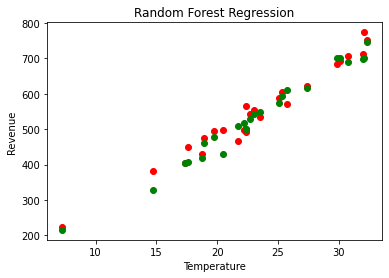

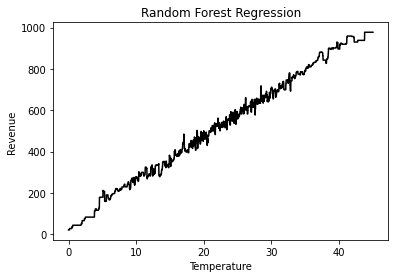

In [8]:
y_pred = regressor.predict(X_test.reshape(-1,1))
y_pred

df = pd.DataFrame({'Real Values':y_test.reshape(-1), 'Predicted Values':y_pred.reshape(-1)})
df

# # Visualising the Random Forest Regression Results  
X_grid = np.arange(min(X), max(X), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))

plt.figure()
plt.scatter(X_test, y_test, color = 'red')
plt.scatter(X_test, y_pred, color = 'green')
plt.title('Random Forest Regression')
plt.xlabel('Temperature')
plt.ylabel('Revenue')
plt.show()

plt.figure()
plt.plot(X_grid, regressor.predict(X_grid), color = 'black')
plt.title('Random Forest Regression')
plt.xlabel('Temperature')
plt.ylabel('Revenue')
plt.show()

**Some insights**  
[A limitation of Random Forest Regression](https://towardsdatascience.com/a-limitation-of-random-forest-regression-db8ed7419e9f)  

**Decision Tree regression**  
[Decision Tree - Regression](https://www.saedsayad.com/decision_tree_reg.htm)  